In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import pickle

In [2]:
dataset = pd.read_csv('../datasets/BenignAndMaliciousDataset.csv')
dataset.head()

,Domain,DNSRecordType,MXDnsResponse,TXTDnsResponse,HasSPFInfo,HasDkimInfo,HasDmarcInfo,Ip,DomainInAlexaDB,CommonPorts,...,ConsoantRatio,NumericRatio,SpecialCharRatio,VowelRatio,ConsoantSequence,VowelSequence,NumericSequence,SpecialCharSequence,DomainLength,Class
0,4455,A,False,False,False,False,False,16984,False,False,...,0.6,0.1,0.0,0.2,10,4,1,0,134,1
1,4456,A,False,False,False,False,False,16984,False,False,...,0.7,0.1,0.0,0.2,12,2,2,1,123,1
2,4457,A,False,False,False,False,False,16984,False,False,...,0.6,0.2,0.0,0.2,16,2,3,0,150,1
3,4458,A,False,False,False,False,False,16984,False,False,...,0.6,0.1,0.0,0.1,9,1,2,0,122,1
4,4459,A,False,False,False,False,False,16984,False,False,...,0.6,0.2,0.0,0.1,10,2,2,0,151,1


### NUMERICAL DATA CONVERSION

In [3]:
dataset.dtypes

Domain                   int64
DNSRecordType           object
MXDnsResponse             bool
TXTDnsResponse            bool
HasSPFInfo                bool
HasDkimInfo               bool
HasDmarcInfo              bool
Ip                       int64
DomainInAlexaDB           bool
CommonPorts               bool
CountryCode             object
RegisteredCountry       object
CreationDate             int64
LastUpdateDate           int64
ASN                      int64
HttpResponseCode         int64
RegisteredOrg           object
SubdomainNumber          int64
Entropy                  int64
EntropyOfSubDomains      int64
StrangeCharacters        int64
TLD                     object
IpReputation              bool
DomainReputation          bool
ConsoantRatio          float64
NumericRatio           float64
SpecialCharRatio       float64
VowelRatio             float64
ConsoantSequence         int64
VowelSequence            int64
NumericSequence          int64
SpecialCharSequence      int64
DomainLe

In [4]:
dataset.select_dtypes(include='object').isna().sum()

DNSRecordType            0
CountryCode          29052
RegisteredCountry    77774
RegisteredOrg        35391
TLD                    170
dtype: int64

only keep DNSRecordType, drop everything else.
drop rows in case of TLD becausse of the amount of NaNs.

In [5]:
dataset[dataset.select_dtypes(include='object').columns[0]].unique().astype('str')

array(['A', 'CNAME', 'MX'], dtype='<U5')

In [6]:
# joint dataset preprocessing script
dataset.drop(dataset.select_dtypes(include='object').columns[1:-1], inplace=True, axis=1)
dataset.dropna(axis=0, inplace=True)
for column in dataset.columns:
    # convertng bool to int
    if dataset[column].dtype == bool:
        dataset[column] = dataset[column].astype('int')
    # label encoding objects.
    elif dataset[column].dtype == object:
        labels = dataset[column].unique().astype('str')
        dataset[column].replace(dict(zip(labels, [i for i in range(len(labels))])), inplace=True)
dataset.shape

(89830, 31)

this can be converted to handle JSON queries later.

In [7]:
dataset.dtypes

Domain                   int64
DNSRecordType            int64
MXDnsResponse            int64
TXTDnsResponse           int64
HasSPFInfo               int64
HasDkimInfo              int64
HasDmarcInfo             int64
Ip                       int64
DomainInAlexaDB          int64
CommonPorts              int64
CreationDate             int64
LastUpdateDate           int64
ASN                      int64
HttpResponseCode         int64
SubdomainNumber          int64
Entropy                  int64
EntropyOfSubDomains      int64
StrangeCharacters        int64
TLD                      int64
IpReputation             int64
DomainReputation         int64
ConsoantRatio          float64
NumericRatio           float64
SpecialCharRatio       float64
VowelRatio             float64
ConsoantSequence         int64
VowelSequence            int64
NumericSequence          int64
SpecialCharSequence      int64
DomainLength             int64
Class                    int64
dtype: object

/tmp/ipykernel_538/2026473694.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


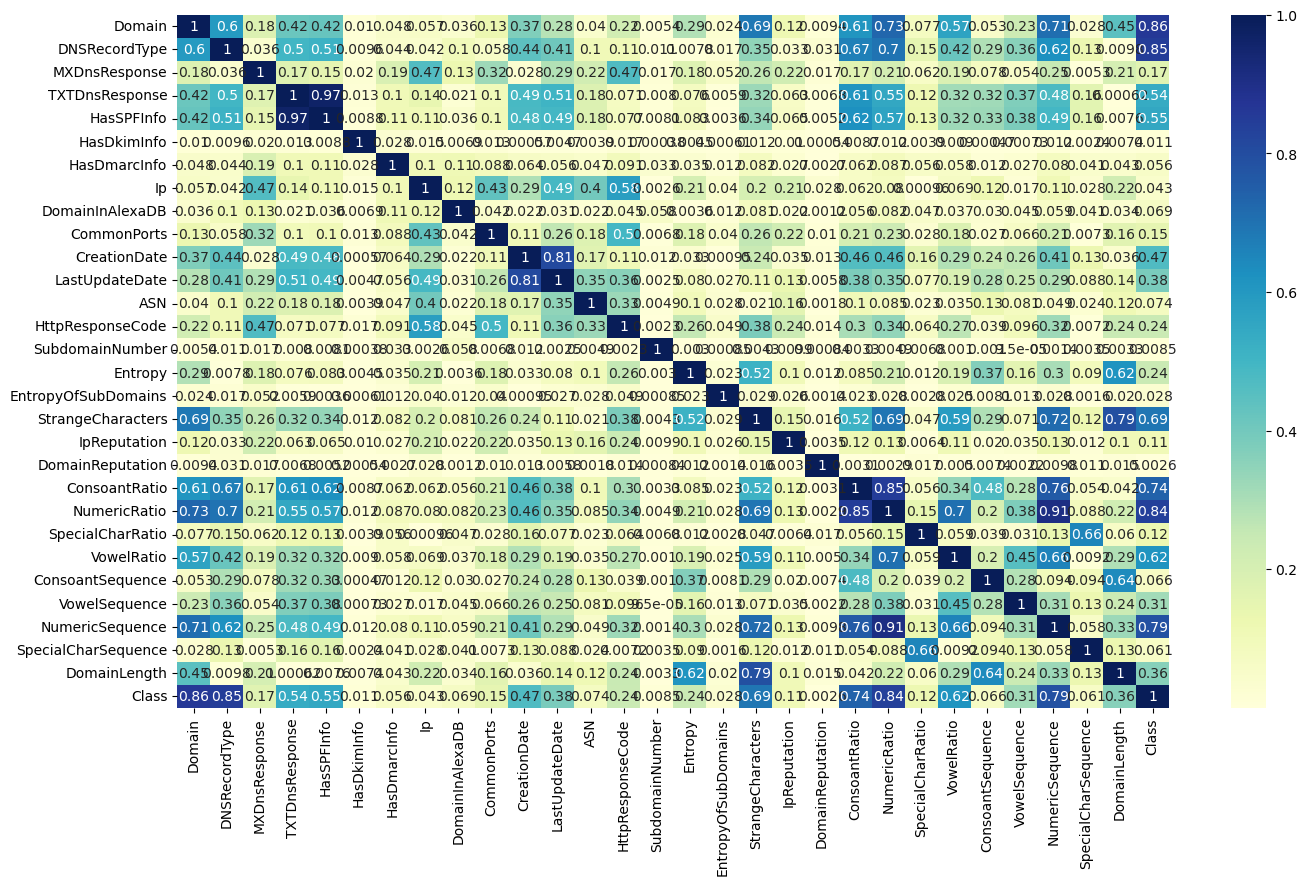

In [23]:
# plotting correlation heatmap
fig = plt.figure(figsize=(16, 9))
corr = dataset.corr().apply(abs)
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)
fig.show()

- TLD is unimportant, so we can drop it entirely. this means that only the DNSRecordType will remains as the labelencoded object feature.

In [17]:
dataset.drop(['TLD'], inplace=True, axis=1)

/tmp/ipykernel_538/1146142377.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


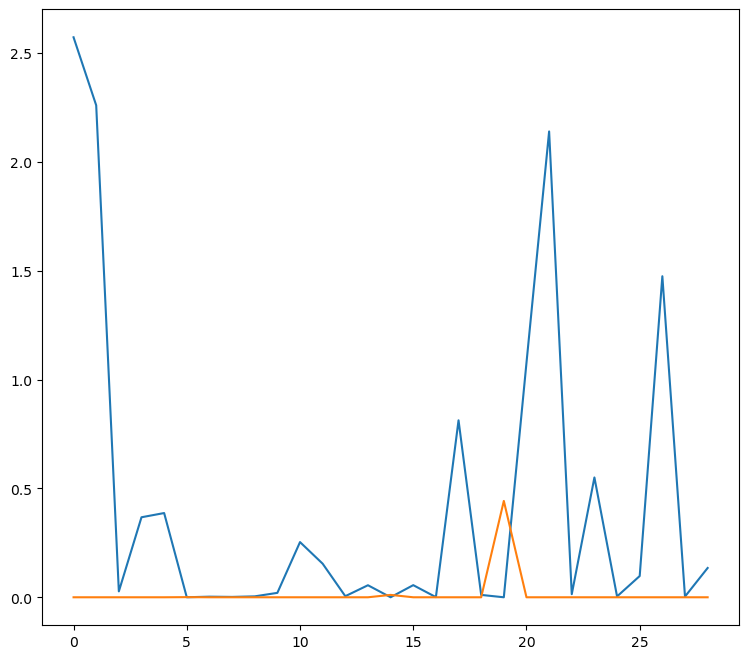

In [26]:
from sklearn.feature_selection import f_classif
F_scores, P_scores = f_classif(dataset.iloc[:, :-1], dataset.iloc[:, -1])
fig = plt.figure(figsize=(9, 8))
plt.plot(F_scores / 10**5)
plt.plot(P_scores)
fig.show()

### Splitting the data

In [28]:
# Seperating the targe vector from feature matrix.
X = dataset.iloc[:, :-1].to_numpy()
y = dataset.iloc[:, -1].to_numpy()
(X.shape, y.shape)

((89830, 29), (89830,))

In [31]:
# Splitting the data into train and test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

### ML Gaming

#### 1. Logistic Regression

In [57]:
# Basic training for model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# Statistics display
print("Confusion matrix for logistic regession:", end='')
print(*confusion_matrix(y_test, y_pred), sep='\n\t\t\t\t\t')
lracc = accuracy_score(y_test, y_pred)
lrpre, lrre, lrfc, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"""
Accuracy: {lracc*100:.4f}%\nPrecision: {lrpre*100:.4f}%
Recall: {lrre*100:.4f}%\nF-score: {lrfc:.4f}
""")

Confusion matrix for logistic regession:[4474    8]
					[   7 4494]

Accuracy: 99.8330%
Precision: 99.8223%
Recall: 99.8445%
F-score: 0.9983



In [58]:
# Testing model on the ENTIRE data.
y_megapred_lr = logreg.predict(X)
print("Confusion matrix for logistic regession:", end='')
print(*confusion_matrix(y, y_megapred_lr), sep='\n\t\t\t\t\t')
lracc = accuracy_score(y, y_megapred_lr)
lrpre, lrre, lrfc, _ = precision_recall_fscore_support(y, y_megapred_lr, average='binary')
print(f"""
Accuracy: {lracc*100:.4f}%\nPrecision: {lrpre*100:.4f}%
Recall: {lrre*100:.4f}%\nF-score: {lrfc:.4f}
""")

Confusion matrix for logistic regession:[44851    52]
					[   43 44884]

Accuracy: 99.8942%
Precision: 99.8843%
Recall: 99.9043%
F-score: 0.9989



In [61]:
# saving the model.
pickle.dump(logreg, open('./models/LogisticRegression.pickle', 'wb'))

#### 2. K-Nearest Neighbours

In [90]:
# finding the best value of K
from sklearn.neighbors import KNeighborsClassifier
KNNExp = np.empty((0, 4))
for i in range(100):
    knn = KNeighborsClassifier(i+1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knactest = accuracy_score(y_test, y_pred)
    knprtest, knretest, knfctest, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    KNNExp = np.vstack([KNNExp, [knactest, knprtest, knretest, knfctest]])
KNNExp = pd.DataFrame(KNNExp, columns=['accuracy', 'precision', 'recall', 'fc'])
KNNExp.describe()

,accuracy,precision,recall,fc
count,100.000000,100.000000,100.000000,100.000000
mean,0.995861,0.993952,0.997812,0.995878
std,0.000493,0.000490,0.000613,0.000491
min,0.994879,0.993137,0.996667,0.994899
25%,0.995770,0.993805,0.997556,0.995787
50%,0.995992,0.994027,0.998000,0.996009
75%,0.996215,0.994245,0.998223,0.996231
max,0.996883,0.996004,0.999111,0.996895


In [94]:
KNNExp.idxmax() + 1

accuracy     4
precision    2
recall       3
fc           4
dtype: int64

- from this, the ideal value of K seems to be 4.

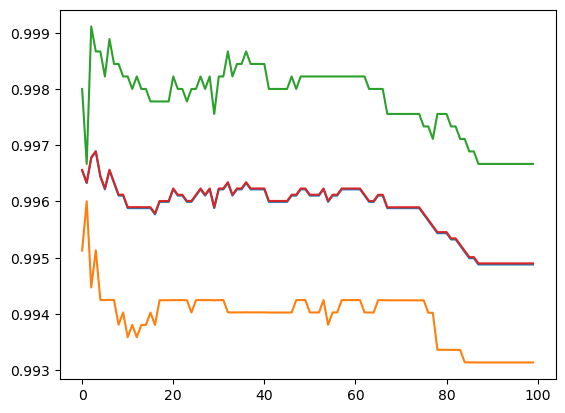

In [96]:
# bonus, plotting the accuracy scores curve.
for column in KNNExp.columns:
    plt.plot(KNNExp[column])
plt.show()

In [101]:
# Building the model
knn = KNeighborsClassifier(4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Statistics display
print("Confusion matrix for K-NN Classifier:", end='')
print(*confusion_matrix(y_test, y_pred), sep='\n\t\t\t\t\t')
knacc = accuracy_score(y_test, y_pred)
knpre, knre, knfc, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"""
Accuracy: {knacc*100:.4f}%\nPrecision: {knpre*100:.4f}%
Recall: {knre*100:.4f}%\nF-score: {knfc:.4f}
""")

Confusion matrix for K-NN Classifier:[4460   22]
					[   6 4495]

Accuracy: 99.6883%
Precision: 99.5130%
Recall: 99.8667%
F-score: 0.9969



In [102]:
# saving the model
pickle.dump(knn, open('./models/KNearestClassifier.pickle', 'wb'))

#### 3. idk 